# Exploring NFC signal recordings

In [1]:
import numpy as np
import scipy
from scipy import signal
from matplotlib import pyplot as plt
import os

from signal_processing import complex_to_mag, shift_down, binary_slicer

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

## File naming

Describe the file names and what they tell us...

- nfc as extension
- specify sample rate, usb standard, antenna, bandwidth, length... ?

In [2]:
PATH = "../data/recordings/"

In [3]:
files = [file for file in os.listdir(PATH) if file.endswith(".nfc")]
files

['2.0-2.nfc',
 '3.0-antenna-3.nfc',
 '3.0-2_lowpassed.nfc',
 '3.0-antenna-probing.nfc',
 '2.0-1.nfc',
 '3.0-antenna-1.nfc',
 '3.0-antenna-2.nfc',
 '3.0-1.nfc']

## Parse file

To parse the file, several element must be taken into account. First, the type of the data in the binary file. Here, we recorded our data as `complex64` values, so we must read them as such as well.

Second, the same sample rate used to record the signal must be used here as well.

In [4]:
samp_rate = int(2e6)  # Is it enough? Nyquist...
nfft = 1024

# The number of samples per period is equal to the sample rate divided by the frequency
npp = samp_rate / 13.56e6
print(npp)
print(847500 / 13.56e6)  # 1/16 might be interesting
print(2 * 13.56e6)

0.14749262536873156
0.0625
27120000.0


In [20]:
file = files[5]
data = np.fromfile(os.path.join(PATH, file), dtype=scipy.complex64)

# Write back to same format:
#data.tofile("test.nffc", "")

#for file in files:
    #sample_rate, data = wav.read(os.path.join(PATH, file))
    #all_X[file[:-4]] = (sample_rate, data)

## Visualize

The signal is mostly very clean, but there are strange artifacts in the recording.

One of them is around the 68'000th point and another around the 340'000th point.

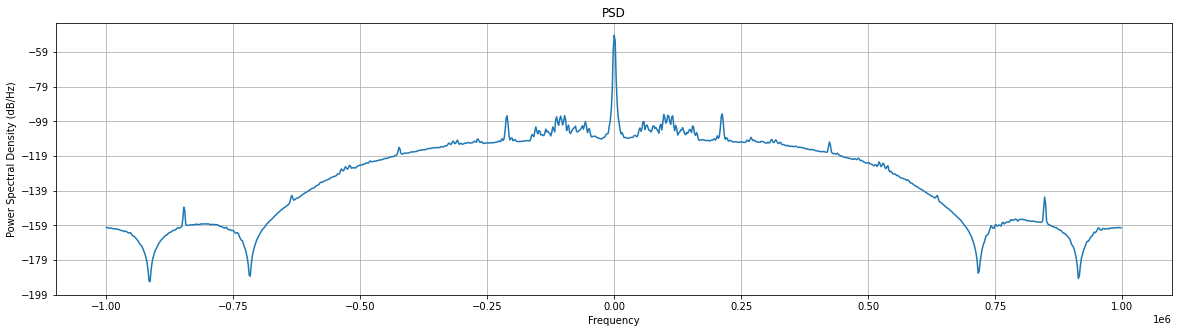

In [6]:
plt.psd(data[0:int(2e6)], NFFT=nfft, Fs=samp_rate)
plt.title("PSD")
plt.show()

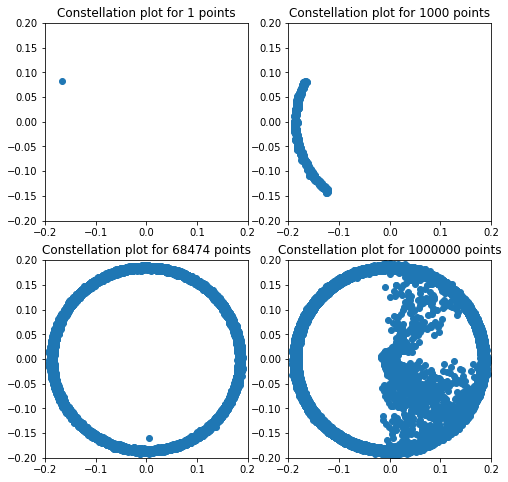

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

nbr_points = [1, 1000, 68474, 1000000]

for i, ax in (t for t in zip(nbr_points, axs.flat)):
    ax.axis([-0.2, 0.2, -0.2, 0.2])
    ax.scatter(np.real(data[0:i]), np.imag(data[0:i]))
    ax.set_title("Constellation plot for {} points".format(i))

## Explore the artifacts we noticed

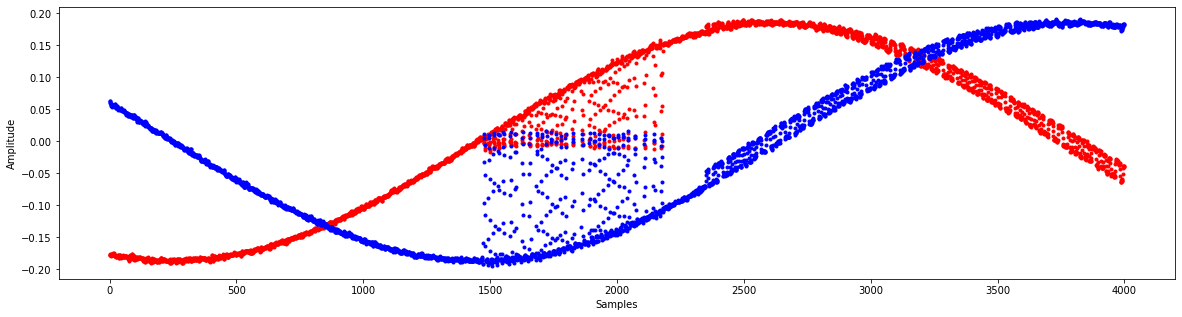

In [70]:
start = 67000
end = 71000

plt.plot(np.real(data[start:end]), 'r.', np.imag(data[start:end]), 'b.')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

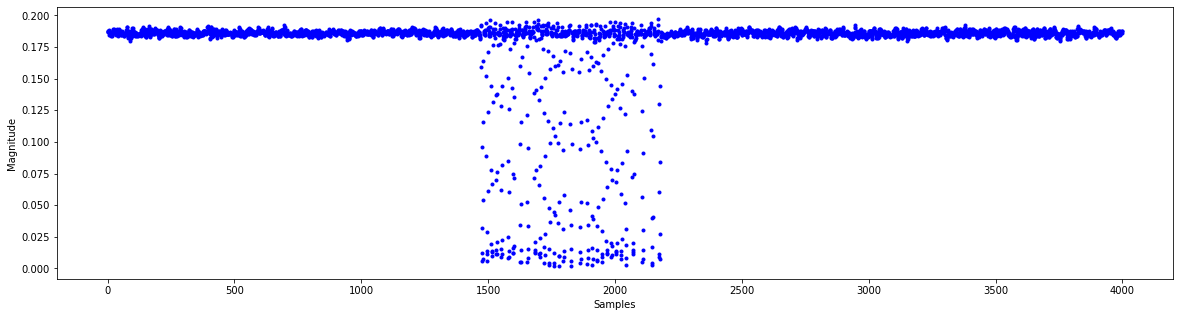

In [39]:
# Plot the magnitude of the signal
plt.plot(complex_to_mag(data[start:end]), 'b.')
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

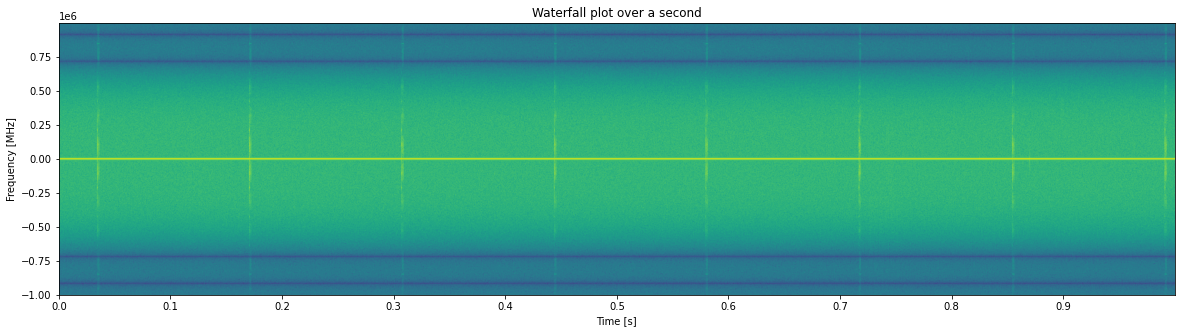

In [38]:
plt.specgram(data[0:int(samp_rate)], NFFT=nfft, Fs=samp_rate)
plt.title("Waterfall plot over a second")
plt.xlabel("Time [s]")
plt.xticks(list(np.arange(0, 1, 0.1)))
plt.ylabel("Frequency [MHz]")
plt.show()

In [41]:
magnitudes = shift_down(complex_to_mag(data), 0.1)
# Transform our complex data to a list of zeros and ones
binary = binary_slicer(magnitudes)

# Find the artifacts' positions in the array
# (only use the first second of data)
indices, = np.where(binary[0:int(2e6)] == 0)

In [30]:
# Keep only the first sample index per artifact area
first_idx = []
first_idx.append(indices[0])
for i in range(1, len(indices)):
    if (indices[i] - indices[i-1]) > 100:
        first_idx.append(indices[i])

print("Artifacts regions:", first_idx)

Artifacts regions: [68475, 341064, 613734, 887385, 1158946, 1433425, 1707966, 1981579]


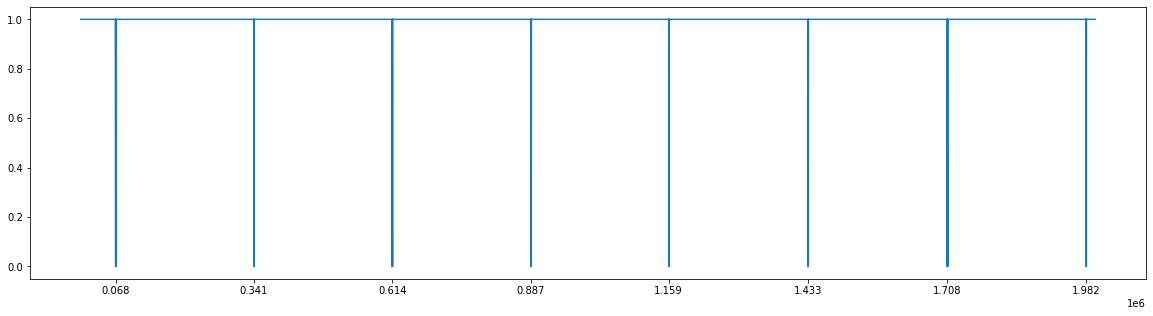

In [29]:
# Plot magnitudes to see artifacts
plt.plot(binary[0:int(2e6)])
plt.xticks(first_idx)
plt.show()

In [47]:
artifacts_period = first_idx[1] - first_idx[0]
period_seconds = artifacts_period / samp_rate

print("Artifacts period in number of samples:", artifacts_period)
print("Artifacts period in seconds:", period_seconds)
print("Number of artifacts per second (freq):", 1 / period_seconds)

Artifacts period in number of samples: 272589
Artifacts period in seconds: 0.1362945
Number of artifacts per second (freq): 7.337053219315526


## Cut the signal into usable chunks

The signal is mostly noise. Let's cut it and keep only parts where data is transmitted.

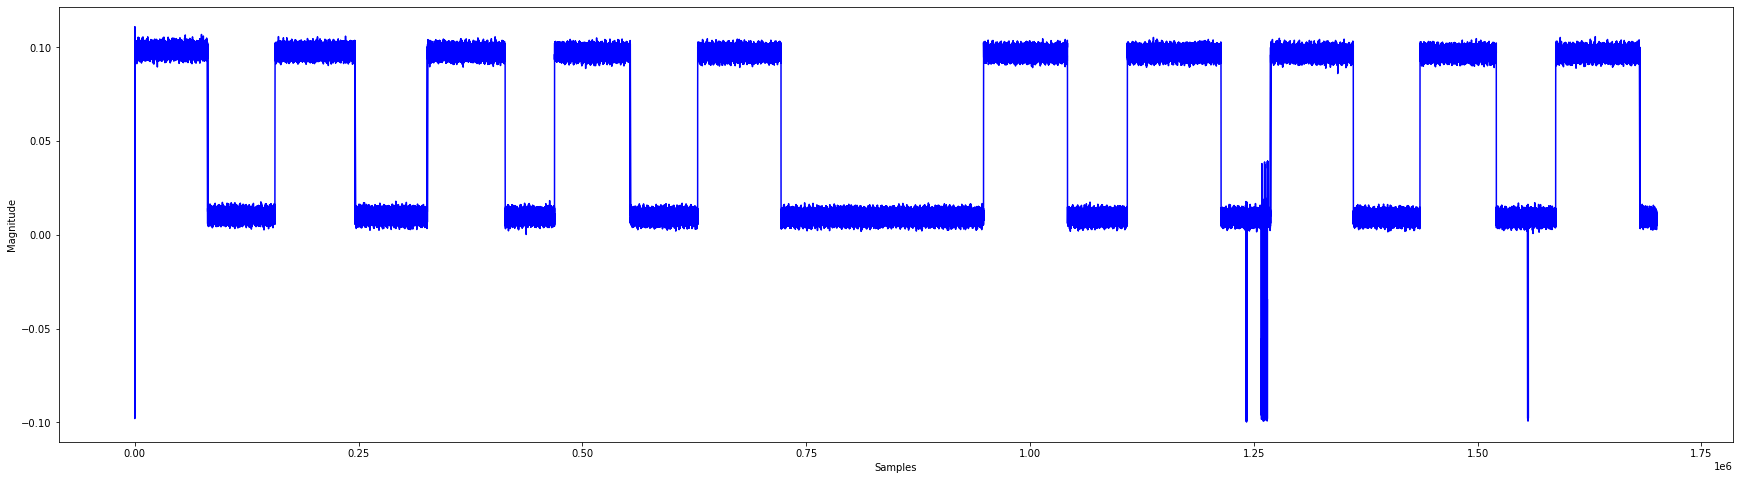

In [93]:
plt.plot(magnitudes[int(3.43e7):int(3.6e7)], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()

## Continuous wavelet transform

In [16]:
widths = np.arange(1, 31)
#cwt = signal.cwt(np.real(data[0:int(1e5)]), signal.ricker, widths)
#plt.imshow(cwt, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
#           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
#plt.show()

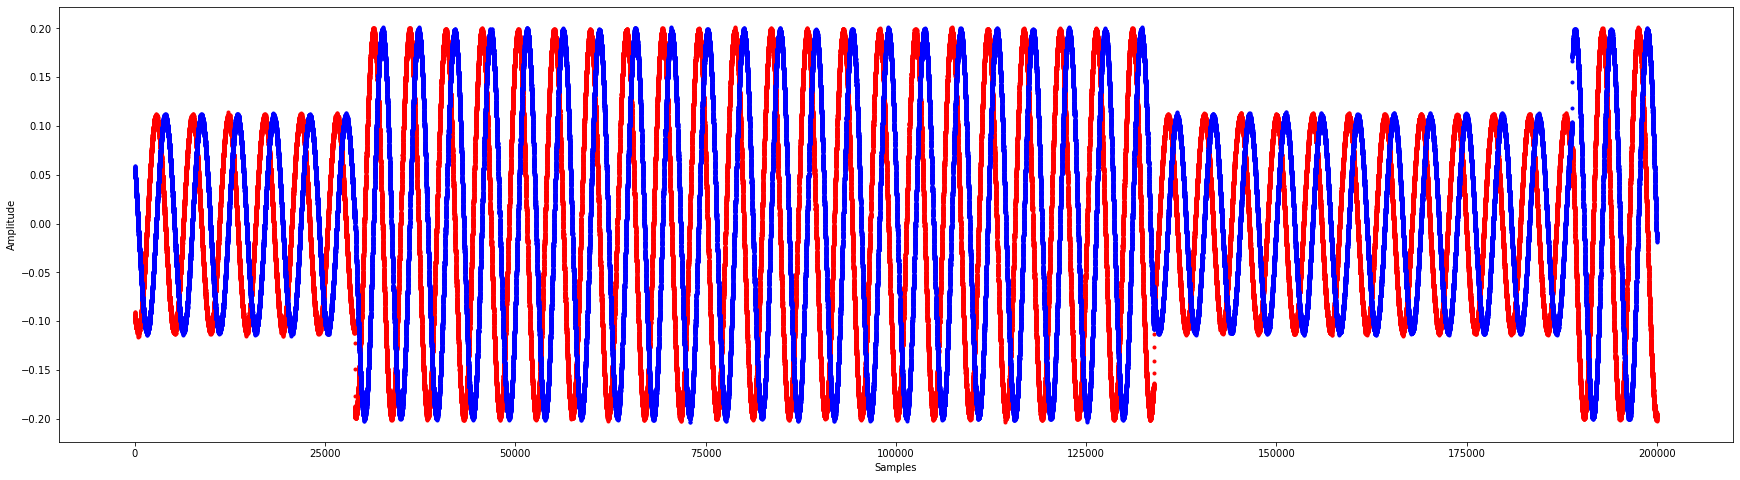

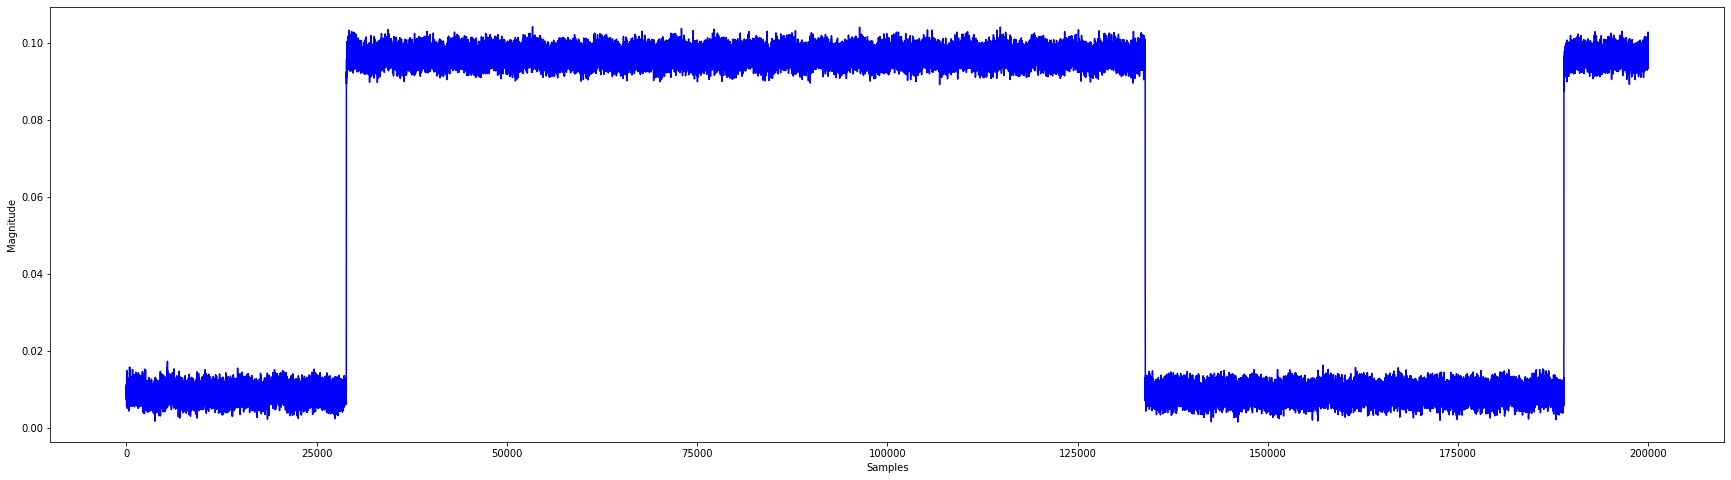

In [83]:
s = int(3.01e7)
e = int(3.03e7)

plt.plot(np.real(data[s:e]), 'r.', np.imag(data[s:e]), 'b.')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

plt.plot(magnitudes[s:e], 'b-',)
plt.xlabel("Samples")
plt.ylabel("Magnitude")
plt.show()